## Introduction

The Acoustic Weld Inspection Project (AKoS) addresses the challenge of ensuring the quality of weld seams in safety-critical components by introducing a novel approach utilizing machine learning, specifically autoencoders. This section provides an overview of the project's goals and the significance of leveraging acoustic data for weld seam inspection.
The Acoustic Weld Inspection Project (AKoS) aims to enhance the quality assurance process for weld seams on safety-critical components using acoustic data. In this report, we present the development of a neural network-based solution for weld seam inspection, focusing on the utilization of autoencoders for anomaly detection.The Acoustic Weld Inspection Project (AKoS) is a pioneering initiative aimed at enhancing the quality assurance process for weld seams in safety-critical components. Traditional methods often fall short in detecting subtle defects, necessitating the exploration of innovative solutions. The AKoS project leverages acoustic data to develop a robust inspection system that can identify abnormalities in weld seams with high accuracy
Weld seam quality is paramount for the structural integrity of components in various industries. Traditional inspection methods, such as visual examination and ultrasonic testing, face limitations in detecting subtle defects, especially those manifesting acoustically. The AKoS project seeks to overcome these limitations by harnessing the capabilities of machine learning, specifically autoencoders, to analyze acoustic signals associated with weld seams.

### Autoencoders in Anomaly Detection

Autoencoders are neural network architectures designed for unsupervised learning. They consist of an encoder and a decoder, which work collaboratively to learn a compressed representation of input data. In anomaly detection applications, such as the AKoS project, autoencoders excel at learning to reconstruct normal data accurately. The core principle lies in the ability to identify anomalies by detecting higher reconstruction errors when presented with abnormal data. This theoretical foundation serves as the basis for the subsequent sections detailing the implementation of autoencoders in the project.

## Solution Overview

The proposed solution leverages autoencoders, a type of neural network designed for unsupervised learning. Autoencoders consist of an encoder and a decoder, with the primary objective of learning a compressed representation of input data. In the context of AKoS, this compressed representation captures essential features of acoustic signals associated with normal weld seams

In [2]:
# IMPORTING LIBRARIES
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import pickle
import librosa
from sklearn.preprocessing import MinMaxScaler
import os
from bitstring import ConstBitStream
import librosa
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import pickle
from tensorflow.keras import layers, models
from scipy.signal import get_window
from librosa.display import specshow
from scipy.fft import fft
from scipy.signal import stft


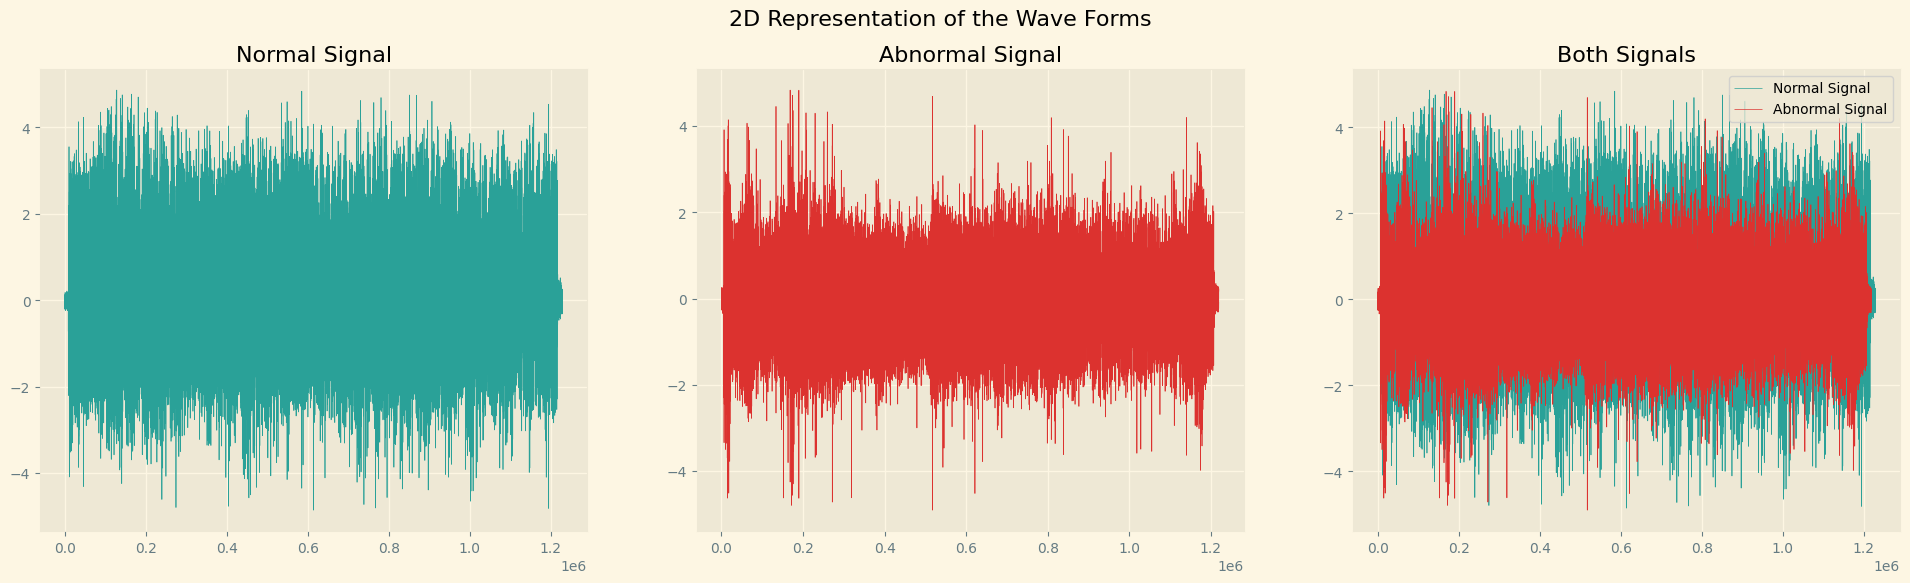

In [3]:
# Understanding the data
def read_i32(filepath):
    with open(filepath, 'rb') as file:
        data = file.read()
        floararray = np.frombuffer(data, dtype=np.float32)
    return floararray

def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

def load_sound_file(path):
    signal = read_i32(path)
    sr = 96000  # Update this with the actual sample rate of your audio files
    return signal, sr

def frame_audio_stft(audio, FFT_size=1024, hop_size=512, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size), dtype=np.float32)
    
    for n in range(frame_num):
        frames[n] = audio[n * frame_len:n * frame_len + FFT_size]
    
    _, _, Zxx = stft(frames, fs=sample_rate, nperseg=FFT_size)
    
    return frames, Zxx  # Return the framed audio and the STFT result

normal_file_path = "./Project_Files/Dataset/npore/Wall_17_AL_io_20220614/L01_09-56-46_io-pass/MikroGefell1_96khz_float32_09-56-46.I32"
abnormal_file_path = "./Project_Files/Dataset/pore/Wall_23_AL_Oel_Zusatz_20220620/L27_14-46-10_nio-oel-pass/MikroGefell1_96khz_float32_14-46-10.I32"

normal_signal, normal_sr = load_sound_file(normal_file_path)
abnormal_signal, abnormal_sr = load_sound_file(abnormal_file_path)

# Use the same parameters as in your original code
FFT_size = 1024
hop_size = 512
sample_rate = 96000

# Frame and calculate STFT for normal and abnormal signals
normal_frames, normal_stft = frame_audio_stft(normal_signal, FFT_size, hop_size, normal_sr)
abnormal_frames, abnormal_stft = frame_audio_stft(abnormal_signal, FFT_size, hop_size, abnormal_sr)

plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
# Plot the waveforms
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Normal Signal
axes[0].set_title("Normal Signal")
axes[0].plot(normal_signal, color=colors[1], linewidth=0.5)

# Abnormal Signal
axes[1].set_title("Abnormal Signal")
axes[1].plot(abnormal_signal, color=colors[5], linewidth=0.5)

# Both Signals
axes[2].set_title("Both Signals")
axes[2].plot(normal_signal, color=colors[1], linewidth=0.5, label="Normal Signal")
axes[2].plot(abnormal_signal, color=colors[5], linewidth=0.5, label="Abnormal Signal")

# Specify legend location
axes[2].legend(loc="upper right")

# Save the figure
fig.suptitle("2D Representation of the Wave Forms", fontsize=16)
plt.show()

##  Fourier Transforms in Acoustic Weld Inspection

Fourier transforms play a crucial role in the Acoustic Weld Inspection Project (AKoS) by providing a frequency-domain representation of acoustic signals. This section explores the theoretical foundation of Fourier transforms, their relevance in signal processing, and their specific application in the project.
###  Role in Feature Extraction

In the provided code for AKoS, Fourier transforms are employed to extract relevant features from acoustic signals. Specifically, the Short-Time Fourier Transform (STFT) is utilized to compute the mel spectrogram, a critical component in characterizing the frequency content of the acoustic data.

### Short-Time Fourier Transform (STFT)

The STFT is a time-dependent extension of the Fourier transform, designed to capture variations in frequency content over short time intervals. It is defined as:

\[ X(t, f) = \int_{-\infty}^{\infty} x(\tau) \cdot w(\tau - t) \cdot e^{-j2\pi f \tau} \, d\tau \]

where:
- \( x(\tau) \) is the input signal,
- \( w(\tau - t) \) is a window function,
- \( X(t, f) \) is the resulting spectrogram.

In the AKoS project, the mel spectrogram is computed using the librosa library, providing a visual representation of the frequency content of the acoustic signals over time.


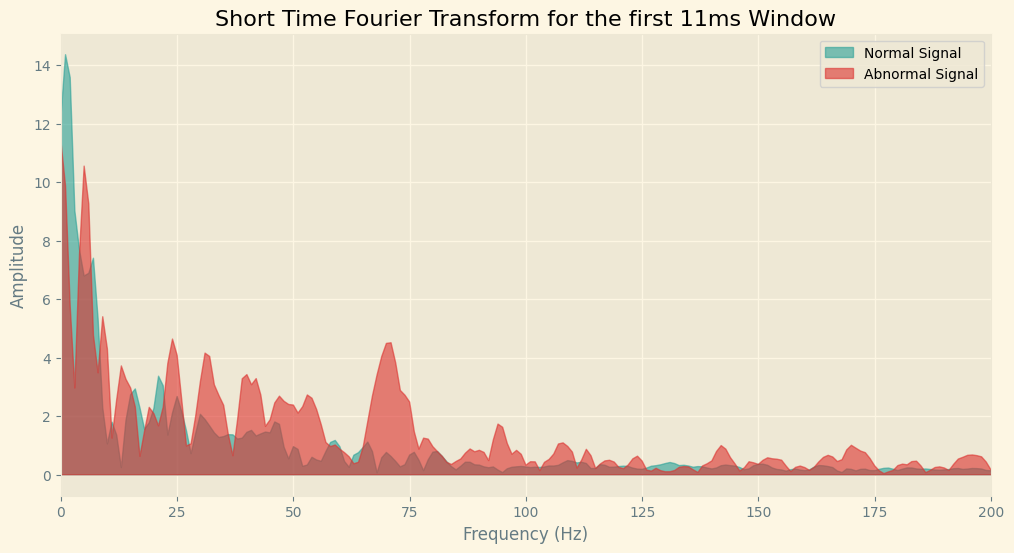

In [4]:
# Short-Time Fourier Transform
n_fft = 1024
hop_length = n_fft + 1
normal_stft = np.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))
abnormal_stft = np.abs(librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))

fig, ax = plt.subplots(figsize=(12, 6))

# Filled area plot for Normal Signal
ax.fill_between(np.arange(len(normal_stft)), 0, normal_stft.flatten(), color=colors[1], alpha=0.6, label="Normal Signal")

# Filled area plot for Abnormal Signal
ax.fill_between(np.arange(len(abnormal_stft)), 0, abnormal_stft.flatten(), color=colors[5], alpha=0.6, label="Abnormal Signal")

ax.set_title(f"Short Time Fourier Transform for the first {n_fft / normal_sr * 1000:.0f}ms Window")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
ax.legend()
ax.set_xlim(0, 200)

plt.show()

### Fourier Transforms in Feature Extraction

The following excerpt from the provided code illustrates the use of Fourier transforms in the feature extraction process:

```python
# Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(
    y=signal,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
```

Here, the `librosa.feature.melspectrogram` function computes the mel spectrogram, and `librosa.power_to_db` converts it to a logarithmic scale for improved representation of perceptual loudness.


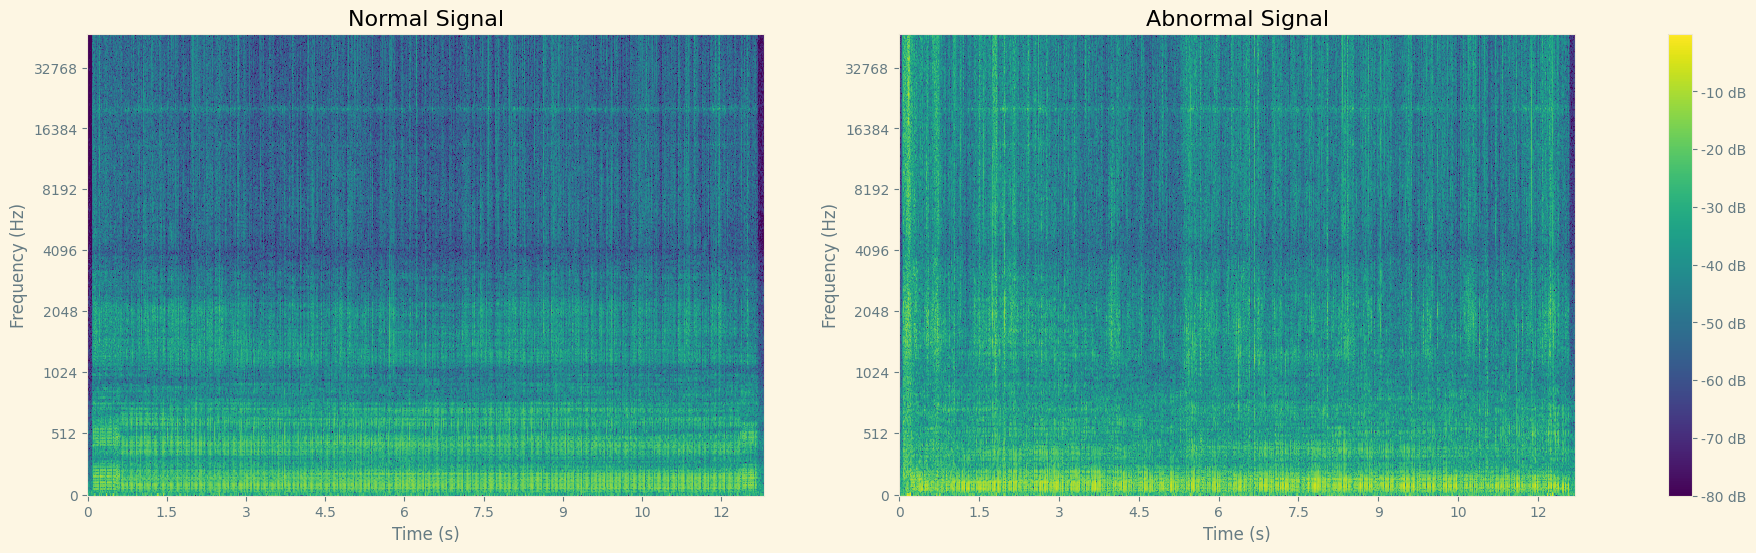

In [7]:
# Normal Fourier Transform 
n_fft = 1024
hop_length = 512

# Calculate power spectrogram for normal signal
normal_stft = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
normal_power_spectrogram = normal_stft ** 2  # Calculate power
normal_spectrogram = librosa.power_to_db(normal_power_spectrogram, ref=np.max)

# Calculate power spectrogram for abnormal signal
abnormal_stft = np.abs(librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length))
abnormal_power_spectrogram = abnormal_stft ** 2  # Calculate power
abnormal_spectrogram = librosa.power_to_db(abnormal_power_spectrogram, ref=np.max)

# Plot Power Spectrograms
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Normal Signal Power Spectrogram
axes[0].set_title("Normal Signal")
librosa.display.specshow(
    normal_spectrogram, sr=normal_sr, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[0]
)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (Hz)")

# Abnormal Signal Power Spectrogram
axes[1].set_title("Abnormal Signal")
librosa.display.specshow(
    abnormal_spectrogram, sr=abnormal_sr, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[1]
)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (Hz)")

# Add colorbar
fig.colorbar(axes[0].collections[0], ax=axes, format="%+2.f dB")

plt.show()


### Mel Spectrogram:

The Mel spectrogram is a crucial feature that provides a frequency-domain representation of the signal's spectrum. It emphasizes the distribution of energy across different frequency bands, offering insights into the acoustic characteristics of weld seams.

Additionally, Fourier transforms contribute to the computation of the pore amplitude feature:

```python
# Pore amplitude feature
pore_amplitude = np.mean(np.abs(librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)
```

Here, the Short-Time Fourier Transform (STFT) is applied to extract the amplitude information within the specified frequency range associated with pores.

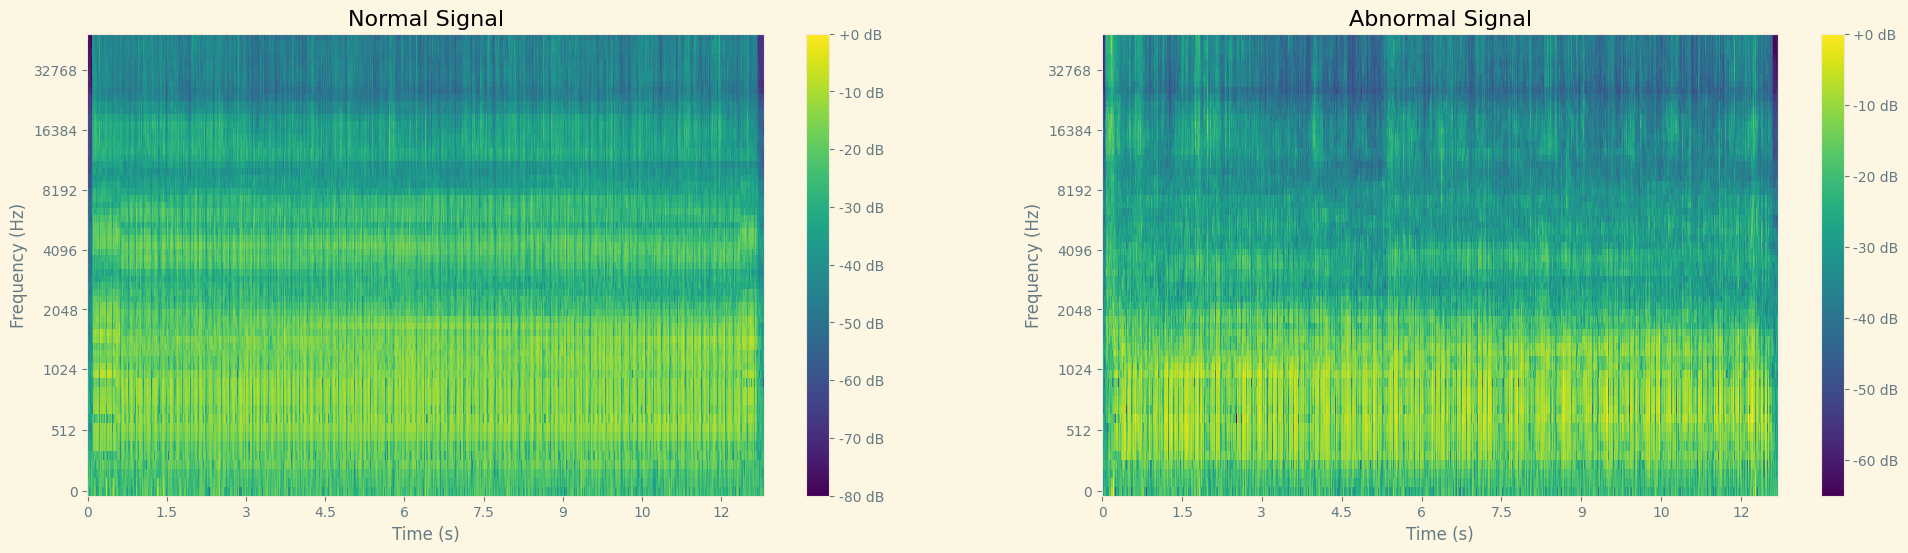

In [8]:
# Mel Spectrogram
n_fft = 1024
hop_length = 512
n_mels = 64

# Compute mel-spectrogram for normal signal
S_normal = librosa.feature.melspectrogram(
    y=normal_signal, sr=normal_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
normal_mel_spectrogram = librosa.power_to_db(S_normal, ref=np.max)

# Compute mel-spectrogram for abnormal signal
S_abnormal = librosa.feature.melspectrogram(
    y=abnormal_signal, sr=abnormal_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
abnormal_mel_spectrogram = librosa.power_to_db(S_abnormal, ref=np.max)

# Plot Mel Spectrograms
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Normal Signal Mel Spectrogram
axes[0].set_title("Normal Signal")
librosa.display.specshow(
    normal_mel_spectrogram,
    sr=normal_sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
    ax=axes[0]
)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (Hz)")

# Check if there is data in the mel spectrogram before attempting to display the colorbar
if np.any(normal_mel_spectrogram):
    fig.colorbar(format="%+2.0f dB", mappable=axes[0].collections[0], ax=axes[0])

# Abnormal Signal Mel Spectrogram
axes[1].set_title("Abnormal Signal")
librosa.display.specshow(
    abnormal_mel_spectrogram,
    sr=abnormal_sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
    ax=axes[1]
)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (Hz)")

# Check if there is data in the mel spectrogram before attempting to display the colorbar
if np.any(abnormal_mel_spectrogram):
    fig.colorbar(format="%+2.0f dB", mappable=axes[1].collections[0], ax=axes[1])

plt.show()

### Data Processing and Feature Extraction

This section outlines the data processing and feature extraction pipeline implemented in the Acoustic Weld Inspection Project (AKoS). The provided code encompasses various functions and libraries for reading, processing, and extracting features from raw acoustic data.
12.1 Reading Raw Acoustic Data

The read_i32 function serves as the initial step in the data processing pipeline. This function reads binary data from a specified file, assuming a 96 kHz sample rate, and converts it into a usable format. The resulting array, data_array, represents the raw acoustic signal.
12.2 Feature Extraction

The core of the feature extraction process lies in the feature_extraction function. This function utilizes several signal processing techniques to derive informative features from the acoustic signal. The features include:

- Mel Spectrogram: A frequency-domain representation of the signal's spectrum, emphasizing the distribution of energy across different frequency bands.

- Pore Amplitude Feature: Captures amplitude information within specified frequency ranges associated with pores or defects in weld seams.

- Spectral Contrast Feature: Measures the difference in amplitude between peaks and valleys in the spectrum, with statistical descriptors (mean and standard deviation) computed for added context.



In [30]:
# Preprocessing functions
sample_rate=96000

def read_i32(filepath):
    with open(filepath, 'rb') as file:
        data = file.read()
        sample_rate = 96000
        float_array = np.frombuffer(data, dtype=np.float32)
    return np.array(float_array), sample_rate

def feature_extraction(signal, sr, n_fft=2048, hop_length=512, n_mels=64, frames=15, pore_frequency_range=(500, 2000), max_feature_length=3069):
    # Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pore amplitude feature
    pore_amplitude = np.mean(np.abs(librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)

    # Spectral contrast feature
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate, hop_length=hop_length)

    # Statistical descriptors for spectral contrast
    mean_spectral_contrast = np.mean(spectral_contrast, axis=0)
    std_spectral_contrast = np.std(spectral_contrast, axis=0)

    # Combine existing and additional features
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels + 3  # 1 for pore amplitude, 2 for mean and std of spectral contrast

    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)

    features = np.zeros((features_vector_size, dims), np.float32)

    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T

    # Insert the pore amplitude feature
    features[:, -3] = pore_amplitude[:features_vector_size]

    # Insert mean and std of spectral contrast
    features[:, -2] = mean_spectral_contrast[:features_vector_size]
    features[:, -1] = std_spectral_contrast[:features_vector_size]

    # Zero-pad or truncate the feature vectors to a consistent length
    if features.shape[0] < max_feature_length:
        padded_features = np.zeros((max_feature_length, dims), dtype=features.dtype)
        padded_features[:features_vector_size, :] = features
        features = padded_features
    elif features.shape[0] > max_feature_length:
        features = features[:max_feature_length, :]

    return features

# Function to process files and extract features
def process_files(directory):
    feature_dataset = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if "MikroGefell1_96khz" in file:
                file_path = os.path.join(root, file)
                data_array, sample_rate = read_i32(file_path)
                # Extract features using the provided function
                features= feature_extraction(data_array, sample_rate)
                feature_dataset.append(features)

    # Convert the list of arrays into a 2D array
    feature_dataset = np.vstack(feature_dataset)
    return feature_dataset


### Loading Train and Test data

In [292]:
# Directory to load data from
normal_directory_path = "./Project_Files/Dataset/npore/"
abnormal_directory_path = "./Project_Files/Dataset/pore/"

# Process files to get feature dataset
train_data= process_files(normal_directory_path)
test_data= process_files(abnormal_directory_path)


In [293]:
# # Define the file path to save data as a pickle
# train_pickle = "./Project_Files/Dataset/train_no_pore_96khz.pkl"
# test_pickle = "./Project_Files/Dataset/test_pore_96khz.pkl"

# # Save the train_data as a pickle file
# with open(train_pickle, 'wb') as file:
#     pickle.dump(train_data, file)
# with open(test_pickle, 'wb') as file: 
#     pickle.dump(test_data, file)


In [12]:

# Read the saved data to apply preprocessing
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz.pkl"

with open(train_pickle, 'rb') as file:
    train_data = pickle.load(file)

with open(test_pickle, 'rb') as file:
    test_data = pickle.load(file)

##  Feature Visualization

This section demonstrates the visualization of key features extracted from acoustic signals in the Acoustic Weld Inspection Project (AKoS). The code provided utilizes matplotlib and librosa libraries to create visual representations of Mel spectrograms, Pore Amplitude Features, and Spectral Contrast Features for both training and test signals.

###  Mel Spectrograms

The Mel spectrogram is a crucial feature that provides a frequency-domain representation of the signal's spectrum. It emphasizes the distribution of energy across different frequency bands, offering insights into the acoustic characteristics of weld seams.

```python
# Plot Mel spectrogram for the training signal
mel_spectrogram_train = librosa.feature.melspectrogram(y=train_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_train = librosa.power_to_db(mel_spectrogram_train, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_train, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 0])
axes[0, 0].set_title("Train Signal Mel Spectrogram")

# Plot Mel spectrogram for the test signal
mel_spectrogram_test = librosa.feature.melspectrogram(y=test_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_test = librosa.power_to_db(mel_spectrogram_test, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_test, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 1])
axes[0, 1].set_title("Test Signal Mel Spectrogram")
```
These visualizations offer a qualitative understanding of the frequency content of both training and test signals.

These plots visualize the amplitude variations within the specified frequency ranges, aiding in the identification of anomalies or defects.

###  Spectral Contrast Features

Spectral Contrast Features measure the difference in amplitude between peaks and valleys in the spectrum. The code visualizes these features for both training and test signals.

```python
# Plot Spectral Contrast Features for the training signal
axes[1, 0].imshow(train_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 0].set_title("Train Signal Spectral Contrast Features")

# Plot Spectral Contrast Features for the test signal
axes[1, 1].imshow(test_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 1].set_title("Test Signal Spectral Contrast Features")
```

These visualizations provide insights into the amplitude variations across different frequency bands, aiding in the detection of distinctive patterns associated with anomalies.

This feature visualization section enhances the interpretability of the extracted features and provides a qualitative assessment of the acoustic characteristics associated with weld seams.

/home/shaxpy/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=960
  warnings.warn(


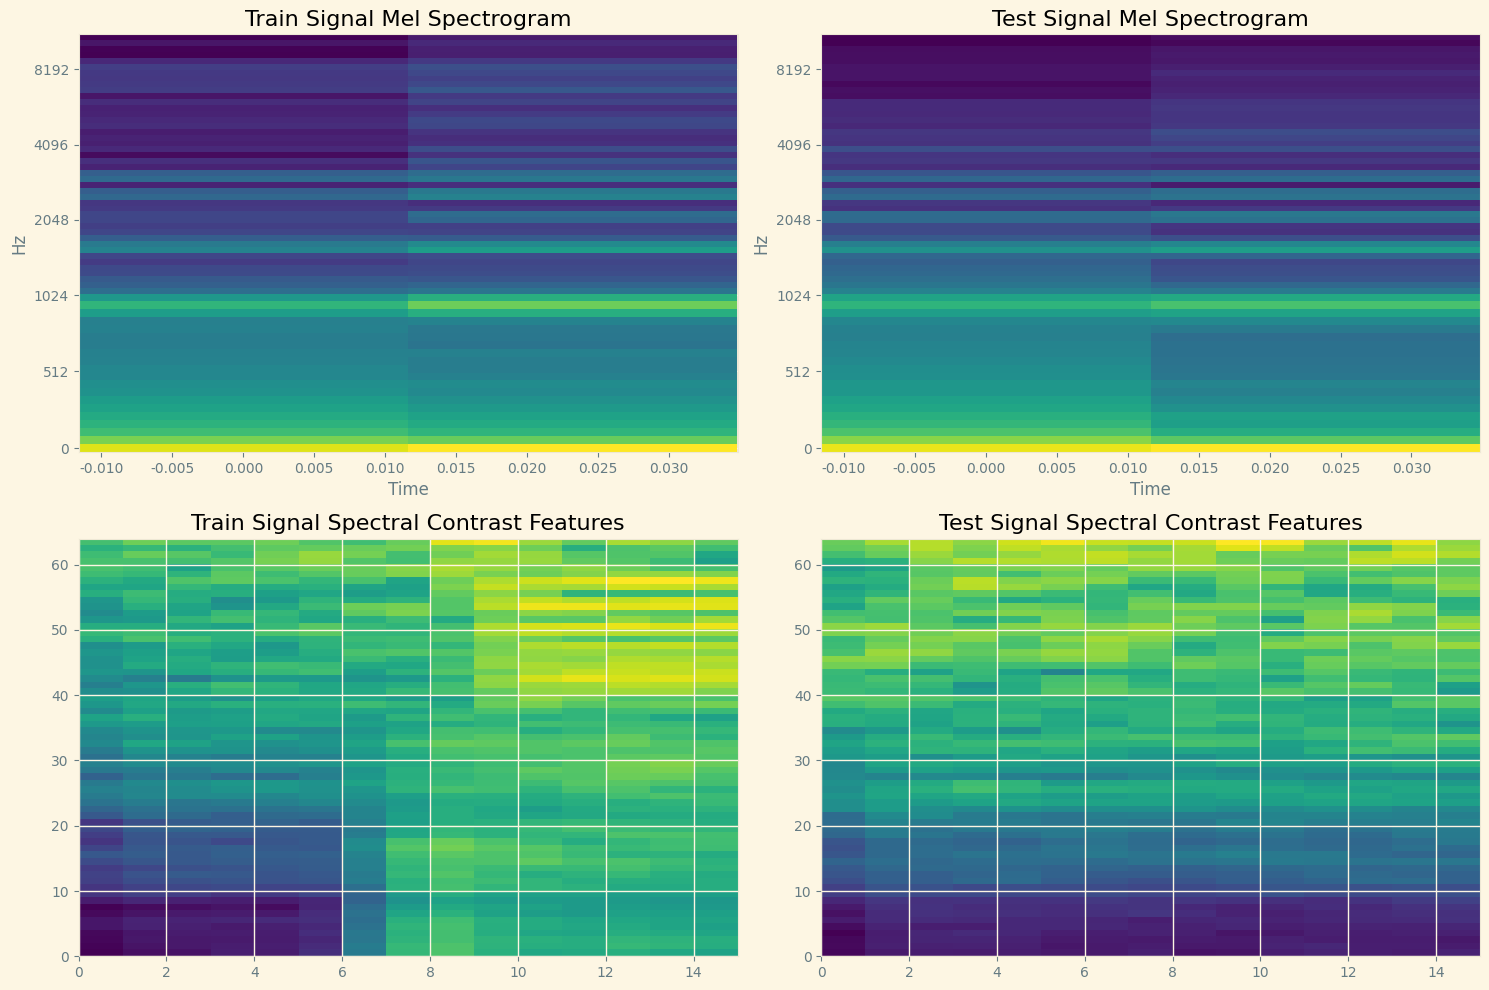

In [13]:
# Function to plot Mel Spectogram and Constrast Feature
import matplotlib.pyplot as plt
import librosa.display

# Example signals (replace with your actual signals)
train_signal = train_data[10, :-3]  
test_signal = test_data[10, :-3]  

# Parameters for feature extraction (replace with your actual parameters)
sample_rate = 96000
n_mels = 64
frames = 15

# Plot the features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Mel spectrogram for the training signal
mel_spectrogram_train = librosa.feature.melspectrogram(y=train_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_train = librosa.power_to_db(mel_spectrogram_train, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_train, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 0])
axes[0, 0].set_title("Train Signal Mel Spectrogram")

# Plot Mel spectrogram for the test signal
mel_spectrogram_test = librosa.feature.melspectrogram(y=test_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_test = librosa.power_to_db(mel_spectrogram_test, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_test, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 1])
axes[0, 1].set_title("Test Signal Mel Spectrogram")

# Plot Spectral Contrast Features for the training signal
axes[1, 0].imshow(train_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 0].set_title("Train Signal Spectral Contrast Features")

# Plot Spectral Contrast Features for the test signal
axes[1, 1].imshow(test_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 1].set_title("Test Signal Spectral Contrast Features")

# Adjust layout
plt.tight_layout()
plt.show()


###  Pore Amplitude Features

The Pore Amplitude Feature captures amplitude information within specified frequency ranges associated with pores or defects in weld seams. This feature is visualized for both training and test signals.

```python
# Plot Pore Amplitude Feature for the training signal
axes[0, 2].plot(train_data[10, -3], label="Train Signal")
axes[0, 2].set_title("Train Signal Pore Amplitude Feature")
axes[0, 2].legend()

# Plot Pore Amplitude Feature for the test signal
axes[1, 2].plot(test_data[10, -3], label="Test Signal")
axes[1, 2].set_title("Test Signal Pore Amplitude Feature")
axes[1, 2].legend()
```
### Pore Amplitude Feature and Signal Visualization

The Pore Amplitude Feature is a critical aspect of the Acoustic Weld Inspection Project (AKoS), providing insights into characteristics associated with pores or defects in weld seams. This section discusses the theoretical foundation of the Pore Amplitude Feature and includes visualizations of the feature for both training and test signals.

### Theoretical Overview of Pore Amplitude Feature

The Pore Amplitude Feature is computed through the Short-Time Fourier Transform (STFT), a technique that reveals the amplitude information within specified frequency ranges associated with pores or defects in weld seams. In the context of AKoS, the Pore Amplitude Feature becomes a valuable descriptor for identifying anomalies in acoustic signals.


/home/shaxpy/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=963
  warnings.warn(


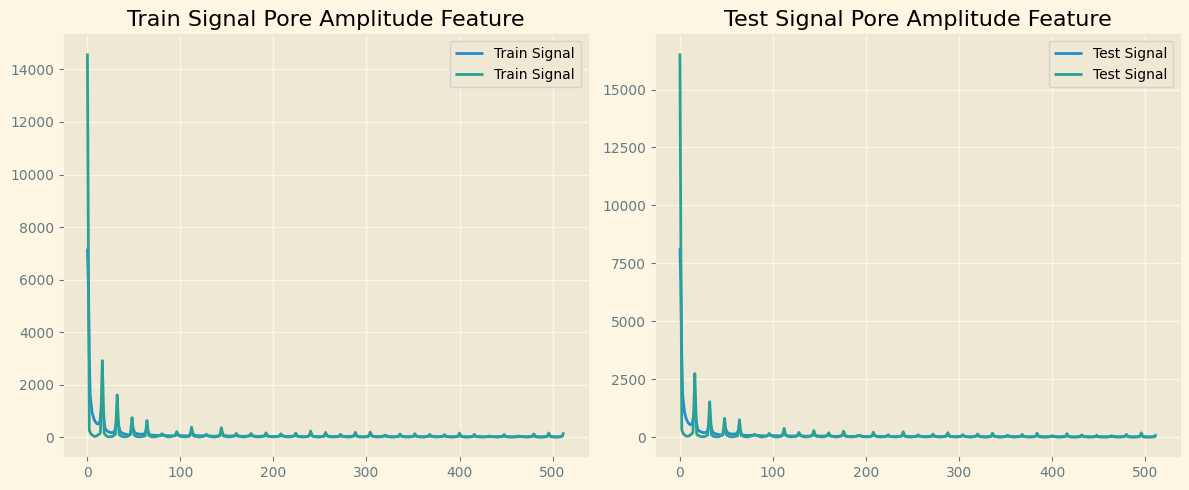

In [18]:
# # Plotting Pore Amplitude Feature
# import matplotlib.pyplot as plt
# import librosa.display

# # Function to calculate Pore Amplitude Feature
# def pore_amplitude_feature(signal, pore_frequency_range=(500, 2000), sample_rate=96000, n_fft=1024, hop_length=512):
#     stft_result = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
#     pore_amplitude = np.mean(np.abs(stft_result[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)
#     return pore_amplitude

# # Example signals (replace with your actual signals)
# train_signal = train_data  
# test_signal = test_data 

# # Calculate Pore Amplitude Feature for the training signal
# pore_amplitude_train = pore_amplitude_feature(train_signal)
# # Calculate Pore Amplitude Feature for the test signal
# pore_amplitude_test = pore_amplitude_feature(test_signal)

# # Plot the features
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Plot Pore Amplitude Feature for the training signal
# axes[0].plot(pore_amplitude_train, label="Train Signal")
# axes[0].set_title("Train Signal Pore Amplitude Feature")
# axes[0].legend()

# # Plot Pore Amplitude Feature for the test signal
# axes[1].plot(pore_amplitude_test, label="Test Signal")
# axes[1].set_title("Test Signal Pore Amplitude Feature")
# axes[1].legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()


## Display the features

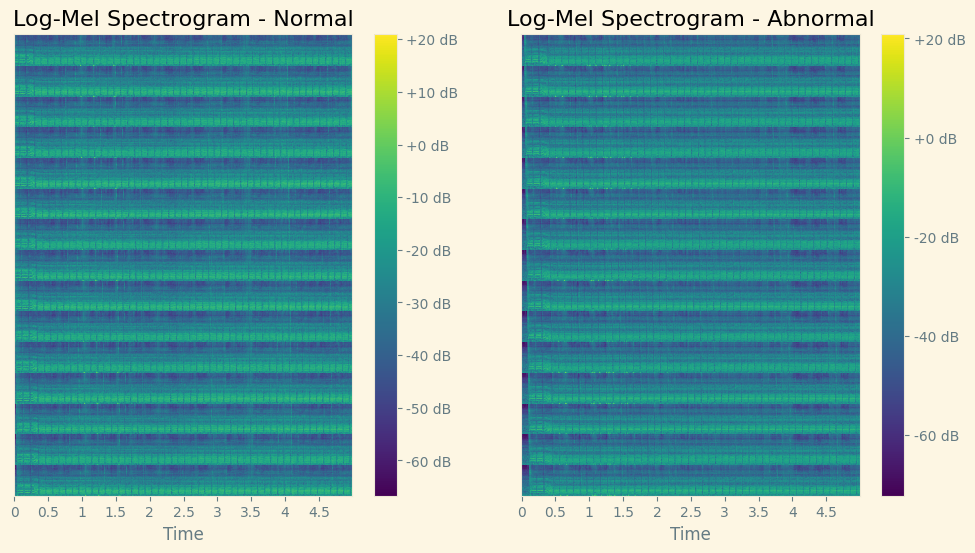

(153450, 963)
(156519, 963)


In [19]:
# Display the shape of the train_data and test_data after feature extraction
plt.figure(figsize=(12, 6))
sample_rate=96000
# Plot the first subplot with the initial part of train_data
plt.subplot(1, 2, 1)
librosa.display.specshow(train_data.T[:, :int(5 * sample_rate / 512)], x_axis='time', sr=sample_rate, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Normal')

# Plot the second subplot with the initial part of test_data
plt.subplot(1, 2, 2)
librosa.display.specshow(test_data.T[:, :int(5 * sample_rate / 512)], x_axis='time', sr=sample_rate, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Abnormal')
plt.show()
print(train_data.shape)
print(test_data.shape)

The first dimension (153450) refers to the number of samples or instances in your dataset. Each row in the matrix corresponds to a separate sample.

The second dimension (963) represents the number of features for each sample. Each column in the matrix corresponds to a feature.



## Scaling and Feature Agglomeration
### Variance Thresholding:

Purpose: The main goal of variance thresholding is to remove features with low variance. Features with low variance indicate that they don't vary much across the dataset and might not contain much information.
Operation: For each feature, the variance is calculated, and features with variance below a certain threshold are removed. This can be useful to eliminate constant or near-constant features that don't contribute much to the model.
### Feature Agglomeration:

Purpose: Feature agglomeration is a technique used for clustering similar features together into groups. The idea is to reduce the dimensionality of the dataset by representing each group of features with a single aggregated feature.
Operation: Features are grouped into clusters, and for each cluster, a representative feature (e.g., the mean or median of the features in the cluster) is computed. The dataset is then transformed to contain these representative features. The number of clusters determines the reduced dimensionality.'

## Why not PCA?
Feature Agglomeration and Principal Component Analysis (PCA) are both dimensionality reduction techniques, but they differ in their approaches and the information they retain.

1. **Feature Agglomeration:**
   - **Approach:** Feature agglomeration is a clustering-based method. It groups similar features together into clusters and represents each cluster with a single aggregated feature.
   - **Information Retention:** Feature agglomeration retains the original features in terms of their cluster representatives. The transformed dataset has fewer features, with each feature representing a cluster.

2. **Principal Component Analysis (PCA):**
   - **Approach:** PCA is a linear transformation technique that finds orthogonal axes (principal components) along which the data has maximum variance.
   - **Information Retention:** PCA retains information by capturing the directions of maximum variance in the data. Principal components are linear combinations of the original features, and they are ordered by the amount of variance they explain.

**Differences:**
   - **Linearity:** PCA is a linear technique, meaning it finds linear combinations of features. Feature agglomeration, on the other hand, is more flexible and can capture non-linear relationships by grouping similar features together.
   - **Representation:** Feature agglomeration retains the original features, though they are clustered. PCA provides a new set of uncorrelated variables (principal components) that may not correspond directly to the original features.
   - **Dimensionality Reduction:** PCA typically reduces dimensionality by creating a smaller set of principal components that explain most of the variance. Feature agglomeration reduces dimensionality by grouping features into clusters.


In [21]:
# Define feature agglomeration and scaling function 
def preprocess_data(train_data, test_data, n_clusters):
    # Adjust the number of clusters based on your requirements
    selector = FeatureAgglomeration(n_clusters=n_clusters)
    scaler = StandardScaler()

    # Standardize the data after feature agglomeration
    X_train_scaled = scaler.fit_transform(train_data)
    X_test_scaled = scaler.transform(test_data)

    # Transform the test data using the same selector

    # Fit and transform the training data with feature agglomeration
    X_train_selected = selector.fit_transform(X_train_scaled)
    # Transform the test data using the same selector
    X_test_selected = selector.transform(X_test_scaled)
    scaler_file_path = "scaler.pkl"

    # Save the scaler object to a file
    with open(scaler_file_path, 'wb') as file:
        pickle.dump(scaler, file)
    selector_file_path = "selector.pkl"

    with open(selector_file_path, 'wb') as file:
        pickle.dump(selector, file)

    return X_train_selected, X_test_selected
    # Define the file path to save the scaler object


In [22]:
# Define the number of clusters for feature agglomeration after scaling 
n_clusters = 12
X_train_selected, X_test_selected = preprocess_data(train_data, test_data, n_clusters)
print(X_train_selected.shape)


(153450, 12)


## Displaying the scaled and agglomerated data

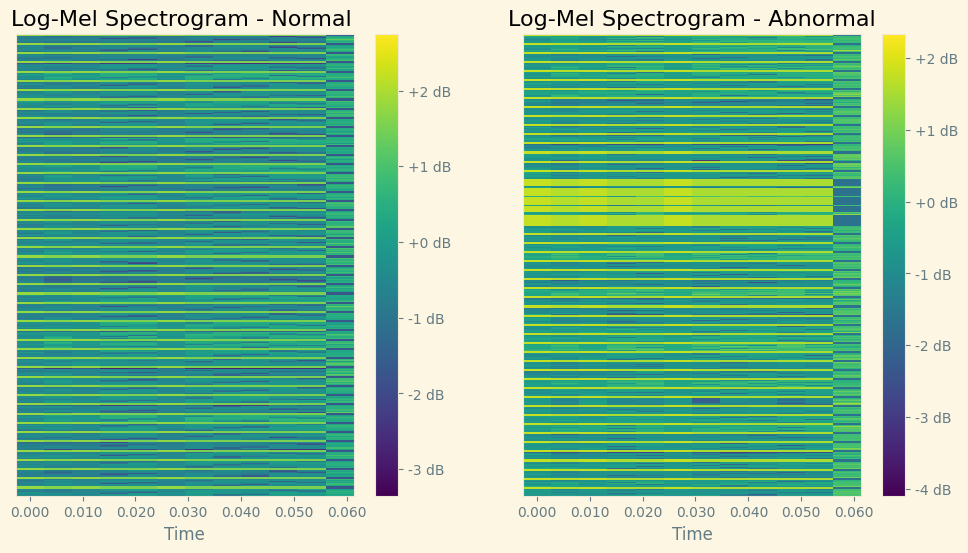

In [23]:
#Display the shape of the train_data and test_data after preprocessing
plt.figure(figsize=(12, 6))

sr=96000
plt.subplot(1, 2, 1)
librosa.display.specshow(X_train_selected[:, :int(5 * sr / 512)], x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Normal ')

# Plot the second subplot with the initial part of test_data
plt.subplot(1, 2, 2)
librosa.display.specshow(X_test_selected[:, :int(5 * sr / 512)], x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Abnormal')

plt.show()


In [24]:
# Define the file path to save processed data
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz_processed.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz_processed.pkl"

# Save the train_data as a pickle file
with open(train_pickle, 'wb') as file:
    pickle.dump(X_train_selected, file)
with open(test_pickle, 'wb') as file:
    pickle.dump(X_test_selected, file)


## Training

In [ ]:
# # Train the autoencoder with data generator
# def learning_rate_scheduler(epoch, lr):

#     if epoch < 15:
#         return lr  # Keep the initial learning rate for the first 10 epochs
#     else:
#       return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# def data_generator(features, batch_size):
#     while True:
#         indices = np.random.choice(features.shape[0], size=batch_size, replace=False)
#         yield features[indices, :], features[indices, :]

# batch_size = 8

# model = models.Sequential([
#     tf.keras.layers.Input(shape=(X_train_selected.shape[1],)),      
#     tf.keras.layers.Dense(16, activation='relu'),  
#     tf.keras.layers.Dense(8, activation='relu'),  
#     tf.keras.layers.Dense(16, activation='relu'),  
#     tf.keras.layers.Dense(X_train_selected.shape[1], activation='sigmoid')
# ])
# X_train_data, X_val_data = train_test_split(X_train_selected, test_size=0.2, random_state=42)

# train_generator = data_generator(X_train_data, batch_size)
# val_generator = data_generator(X_val_data, batch_size)

# lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
# history = model.fit(train_generator, epochs=30, steps_per_epoch=len(X_train_data)//batch_size, validation_data=val_generator, validation_steps=len(X_val_data)//batch_size,callbacks=[lr_scheduler])
# model.save('pore_classifier.h5')

Epoch 1/30
15345/15345 [==============================] - 147s 10ms/step - loss: 0.4794 - accuracy: 0.6624 - val_loss: 0.4417 - val_accuracy: 0.7092 - lr: 1.0000e-04
Epoch 2/30
15345/15345 [==============================] - 146s 10ms/step - loss: 0.4408 - accuracy: 0.7352 - val_loss: 0.4425 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 3/30
15345/15345 [==============================] - 147s 10ms/step - loss: 0.4404 - accuracy: 0.9173 - val_loss: 0.4416 - val_accuracy: 0.9405 - lr: 1.0000e-04
Epoch 4/30
15345/15345 [==============================] - 143s 9ms/step - loss: 0.4393 - accuracy: 0.9451 - val_loss: 0.4405 - val_accuracy: 0.9430 - lr: 1.0000e-04
Epoch 5/30
15345/15345 [==============================] - 143s 9ms/step - loss: 0.4410 - accuracy: 0.9477 - val_loss: 0.4352 - val_accuracy: 0.9473 - lr: 1.0000e-04
Epoch 6/30
15345/15345 [==============================] - 144s 9ms/step - loss: 0.4401 - accuracy: 0.9486 - val_loss: 0.4433 - val_accuracy: 0.9483 - lr: 1.0000e-04
Epoch 7

/home/shaxpy/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


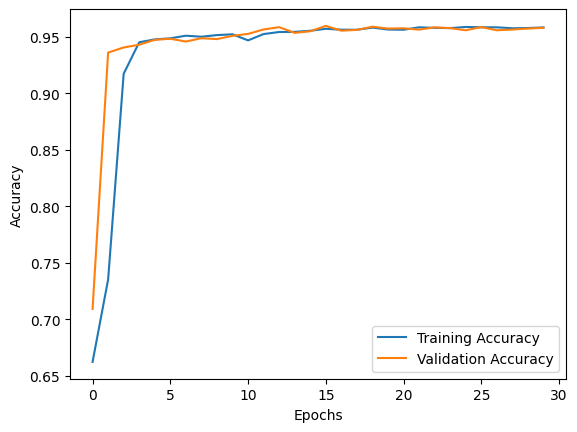

In [ ]:
# Plotting Accuracy and Loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Model Summary
model = tf.keras.models.load_model('pore_classifier.h5')
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                208       
                                                                 
 dense_41 (Dense)            (None, 8)                 136       
                                                                 
 dense_42 (Dense)            (None, 16)                144       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
Total params: 692 (2.70 KB)
Trainable params: 692 (2.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Testing on Original Samples
#### Train_Data : Wall_17_AL_io_20220614
#### Test_Data : Wall_23_AL_Oel_Zusatz_20220620

In [25]:
# Load Train and Test processed file
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz_processed.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz_processed.pkl"

with open(train_pickle, 'rb') as file:
    train_data_process = pickle.load(file)
with open(test_pickle, 'rb') as file:
    test_data_process = pickle.load(file)

X_train_selected=train_data_process
X_test_selected=test_data_process
threshold=0.43866489608647974

4892/4892 [==============================] - 11s 2ms/step
Number of instances where Non-Pore is high: 31757
Number of instances where Pores is high: 124762
Pore


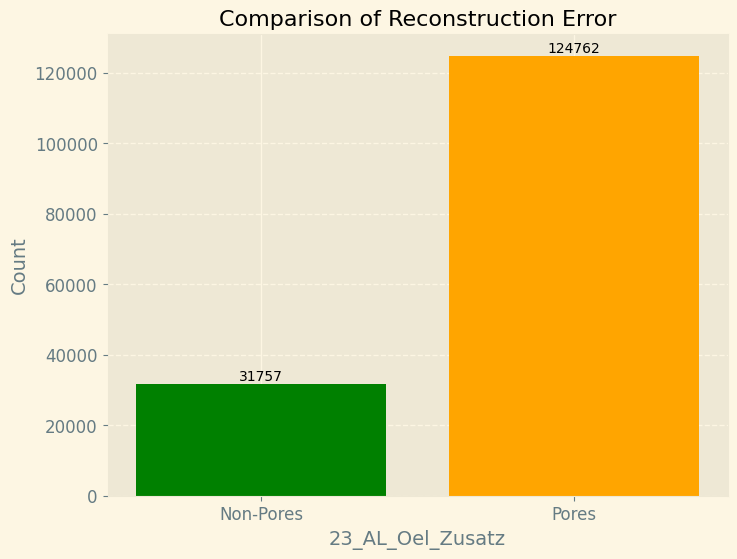

In [31]:
# Load the trained autoencoder model
model = tf.keras.models.load_model('pore_classifier.h5')

# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_train_selected)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_train_selected - reconstructed_data), axis=1)

reconstructed_data = model.predict(X_test_selected)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected - reconstructed_data), axis=1)

# Plot the reconstruction errors for train and test data

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['green', 'orange'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('23_AL_Oel_Zusatz', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

In [27]:
# # Testing threshold
# from sklearn.metrics import precision_score, recall_score, f1_score

# rec_train=np.mean(reconstruction_errors_train)
# rec_test=np.mean(reconstruction_errors_test)

# # Calculate the threshold (you may want to fine-tune this value)
# threshold = (np.max(np.mean(rec_train)) + np.min(np.mean(rec_train))) * 0.5
# print(threshold)
# # Classify samples as normal or abnormal
# predictions_normal = (rec_train) > threshold
# predictions_test = (rec_test) > threshold

# if predictions_normal or predictions_test:
#     classification = "Pore"
# else:
#     classification = "Non-Pore"


## Testing on 3 kinds of Samples: 
###  AL_Oel, GF50, and GF90

In [28]:
# Loading scaler and selector objects from pickle files

scaler_file_path = "scaler.pkl"
# Save the scaler object to a file

with open(scaler_file_path, 'rb') as file:
    scaler = pickle.load(file)
selector_file_path = "selector.pkl"
with open(selector_file_path, 'rb') as file:
    selector = pickle.load(file)

### Test1: Wall_12_AL_Oel_20220615

96/96 [==============================] - 0s 2ms/step
Number of instances where Non-Pore is high: 332
Number of instances where Pores is high: 2737
Pore


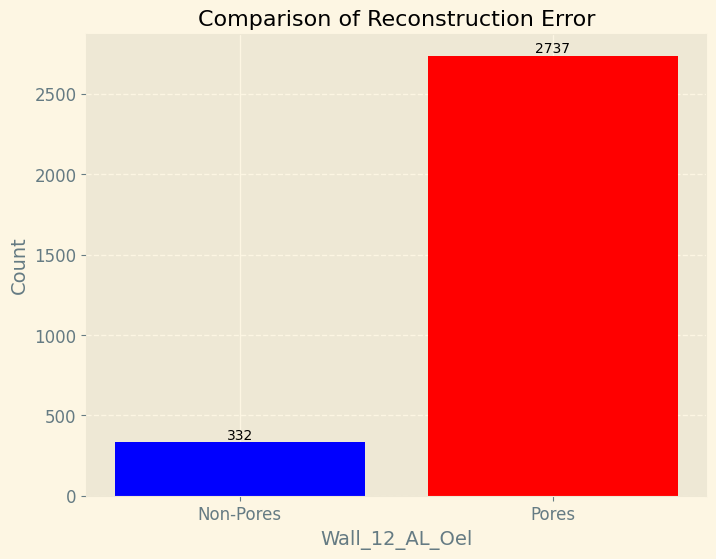

In [33]:
# Loading AL_Oel_20220615 Data
test_directory = "./Project_Files/test/Wall_12_AL_Oel_20220615/"
normal_dir = "./Project_Files/normal/Wall_17_AL_io_20220614/"

# Single sample # L24_10-34-35_no-oel_nio-oel-fail-AL_OEL 
test_directory = "./Project_Files/Test_data/L33_09-26-19_nio-gas50-pass-GF50/"
normal_dir = "./Project_Files/normal/L08_09-59-44_io-pass/"

testing_file= process_files(test_directory)
normal_file= process_files(normal_dir)

model = tf.keras.models.load_model('pore_classifier.h5')

# Standardize the data after feature agglomeration
X_test_scaled_ = scaler.transform(testing_file)

# Transform the test data using the same selector
X_test_selected_ = selector.transform(X_test_scaled_)
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# Standardize the data after feature agglomeration
x_normal = scaler.transform(normal_file)

# Transform the test data using the same selector
X_normal = selector.transform(x_normal)
# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_normal)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Wall_12_AL_Oel', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

### Test2: Wall_22_AL_GF50_20220615

96/96 [==============================] - 0s 2ms/step
Number of instances where Non-Pore is high: 52
Number of instances where Pores is high: 3017
Pore


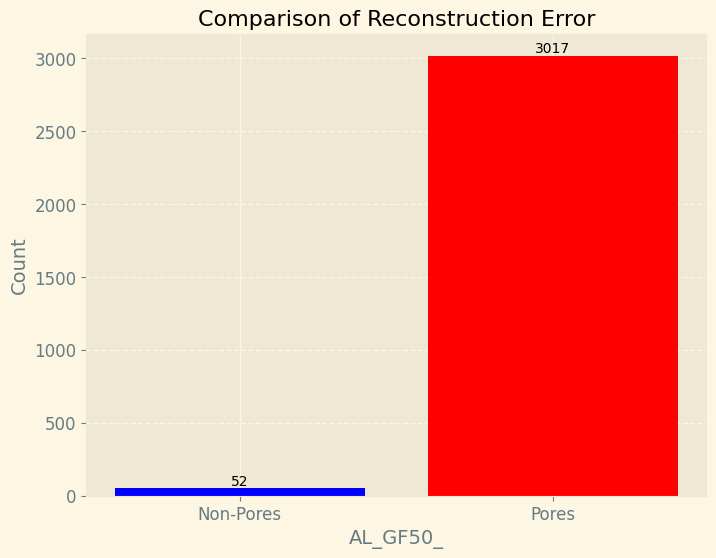

In [32]:
# Loading AL_GF50 Data
test_directory = "./Project_Files/test/Wall_22_AL_GF50_20220615/"
normal_dir = "./Project_Files/normal/Wall_17_AL_io_20220614/"

# L24_09-20-21_nio-gas50-pass-GF50 - single sample
test_directory = "./Project_Files/Test_data/L24_09-20-21_nio-gas50-pass-GF50/"
normal_dir = "./Project_Files/normal/L08_09-59-44_io-pass/"

testing_file= process_files(test_directory)
normal_file= process_files(normal_dir)

model = tf.keras.models.load_model('pore_classifier.h5')

# Standardize the data after feature agglomeration
X_test_scaled_ = scaler.transform(testing_file)

# Transform the test data using the same selector
X_test_selected_ = selector.transform(X_test_scaled_)
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# Standardize the data after feature agglomeration
x_normal = scaler.transform(normal_file)

# Transform the test data using the same selector
X_normal = selector.transform(x_normal)
# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_normal)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('AL_GF50_', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

### Test3: Wall_13_AL_GF90_20220614

In [34]:
# Loading AL_GF90 Data

# L24_09-20-21_nio-gas50-pass-GF50 - SAMPLE NAME
test_directory = "./Project_Files/test/Wall_13_AL_GF90_20220614/"
normal_dir = "./Project_Files/normal/L08_09-59-44_io-pass/"

testing_file= process_files(test_directory)
normal_file= process_files(normal_dir)

model = tf.keras.models.load_model('pore_classifier.h5')

# Standardize the data after feature agglomeration
X_test_scaled_ = scaler.transform(testing_file)

# Transform the test data using the same selector
X_test_selected_ = selector.transform(X_test_scaled_)
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# Standardize the data after feature agglomeration
x_normal = scaler.transform(normal_file)

# Transform the test data using the same selector
X_normal = selector.transform(x_normal)
# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_train_selected)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_train_selected - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('AL_GF90', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

4796/4796 [==============================] - 11s 2ms/step
